In [ ]:
import ctypes
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [11]:
with open("../src/model_ctypes/_grandi/model.c") as f:
    lines = f.readlines()[6:345]
    
lines[:5]

[' * CONSTANTS[0] is Bmax_CaM in component buffca (mM).\n',
 ' * CONSTANTS[128] is Bmax_SLhighj in component buffca (mM).\n',
 ' * CONSTANTS[133] is Bmax_SLhighsl in component buffca (mM).\n',
 ' * CONSTANTS[129] is Bmax_SLlowj in component buffca (mM).\n',
 ' * CONSTANTS[134] is Bmax_SLlowsl in component buffca (mM).\n']

In [43]:
prefixes = ['CONSTANTS', 'STATES', 'ALGEBRAIC']
result = {p: [] for p in prefixes}

for line in lines:
    
    line = line.split()[1:]
    
    x = line[0]
    
    for p in result:
        if x.startswith(p):
            n = int(x[len(p) + 1:-1])
            what = line[2]
            where = line[5]
            units = line[6][1:-2]
            result[p].append([n, what, where, units])

In [44]:
for p, x in result.items():
    result[p] = sorted(x, key = lambda x: x[0])

In [48]:
legend_constants = pd.DataFrame(result['CONSTANTS'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_constants['value'] = None
legend_constants.head()

,name,component,units,value
index,,,,
0,Bmax_CaM,buffca,mM,None
1,Bmax_SR,buffca,mM,None
2,Bmax_TnChigh,buffca,mM,None
3,Bmax_TnClow,buffca,mM,None
4,Bmax_myosin,buffca,mM,None


In [49]:
legend_states = pd.DataFrame(result['STATES'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_states['value'] = None
legend_states.head()

,name,component,units,value
index,,,,
0,CaM,buffca,mM,None
1,Myoc,buffca,mM,None
2,Myom,buffca,mM,None
3,SLH_jn,buffca,mM,None
4,SLH_sl,buffca,mM,None


In [66]:
legend_algebraic = pd.DataFrame(result['ALGEBRAIC'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_algebraic['value'] = 0
legend_algebraic.head()

,name,component,units,value
index,,,,
0,ical_d_inf,ical_d,dimensionless,0
1,ical_f_inf,ical_f,dimensionless,0
2,ikr_xr_inf,ikr_xr,dimensionless,0
3,iks_xs_inf,iks_xs,dimensionless,0
4,ikur_r_inf,ikur_ikur_r,dimensionless,0


# MAIN

In [2]:
dirname = '../src/model_ctypes/_grandi/'
filename_so = os.path.join(dirname, 'model.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]
model.run.restype = ctypes.c_int


legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')

In [3]:
# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_states_default.restype = ctypes.c_void_p


# model.initialize_constants_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_constants_default.restype = ctypes.c_void_p

# values = np.zeros(len(legend_states))
# model.initialize_states_default(values)
# legend_states['value'] = values

# values = np.zeros(len(legend_constants))
# model.initialize_constants_default(values)
# legend_constants['value'] = values

In [4]:
# legend_constants[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_constants.csv"), index=False)
# legend_states[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_states.csv"), index=False)
# legend_algebraic[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_algebraic.csv"), index=False)

In [5]:
S = legend_states.copy()
C = legend_constants.copy()
A = legend_algebraic.copy()

In [6]:
C['stim_duration'] = 1
C['amplitude'] = legend_constants['amplitude'] * 5

In [23]:
t_sampling = 1

#C['STIM_PERIOD'] = 1
stim_period = C['stim_period']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-3

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
# output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
# t = np.zeros(n_samples_per_stim * n_beats + 1)

In [24]:
status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

print(status)

2


In [25]:
output = pd.DataFrame(output, columns=legend_states.index)
# output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)

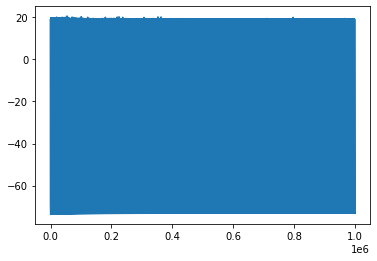

In [26]:
plt.plot(output.V)

In [27]:
atol = (output.abs().min() / 10).clip(lower=1e-6, upper=1e-3)
atol = np.power(10, np.log10(atol).round())

s = ""
for i, name in enumerate(atol.index):
    x = f'/*{name}*/ {atol[name]}, '
    s += x
    s += (20 - len(x)) * ' '
    if i % 5 == 4:
        s += '\n'

In [28]:
print(s)

/*CaM*/ 0.0001,     /*Myoc*/ 0.001,     /*Myom*/ 0.001,     /*SLH_jn*/ 0.001,   /*SLH_sl*/ 0.001,   
/*SLL_jn*/ 0.001,   /*SLL_sl*/ 0.001,   /*SRB*/ 0.001,      /*TnCHc*/ 0.001,    /*TnCHm*/ 0.001,    
/*TnCL*/ 0.001,     /*Ca_i*/ 1e-05,     /*Ca_jn*/ 0.0001,   /*Ca_sl*/ 1e-05,    /*NaB_jn*/ 0.001,   
/*NaB_sl*/ 0.001,   /*Na_jn*/ 0.001,    /*Na_sl*/ 0.001,    /*Ca_sr*/ 0.001,    /*Csqn*/ 0.001,     
/*V*/ 0.001,        /*d*/ 1e-06,        /*f*/ 0.001,        /*fCaB_jn*/ 0.001,  /*fCaB_sl*/ 0.001,  
/*K_i*/ 0.001,      /*xr*/ 0.0001,      /*xs*/ 0.001,       /*Na_i*/ 0.001,     /*ikur_r*/ 0.0001,  
/*s*/ 0.001,        /*h*/ 1e-06,        /*j*/ 1e-06,        /*m*/ 0.001,        /*hl*/ 0.001,       
/*ml*/ 0.001,       /*x*/ 0.0001,       /*y*/ 0.001,        /*i*/ 1e-06,        /*o*/ 1e-06,        
/*ryr_r*/ 0.001,    
